TODO:
* experiment with narrower sampling of thetas / less trials / fixed presentation time
* analysis with train set / test set

In [1]:
%run experiment1.ipynb

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

numpy       : 2.2.4
MotionClouds: unknown
manim       : 0.19.0
pandas      : 2.2.3
matplotlib  : 3.10.1
scipy       : 1.15.2

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local



## one logistic regression per session

Fit inspired by https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html


In [2]:
theta_trials = np.array(parameters['theta'])*180/np.pi
theta_max = theta_trials.max()

In [3]:
# Best params:  {'batch_size': 43, 'etab1': 0.02599314502728014, 'etab2': 5.0944448108516174e-05, 'learning_rate': 0.002297260309801149, 'amsgrad': True, 'logit0': 0.4573043402598472, 'log_wt': -0.9146554255022143}
# Best params:  {'batch_size': 18, 'etab1': 0.0070904816673135465, 'etab2': 2.5165272841905336e-05, 'learning_rate': 0.020789720492225022, 'amsgrad': True, 'logit0': 0.07573040934517006, 'log_wt': 0.5002909989326557}
# Best params:  {'batch_size': 8, 'etab1': 0.0024040809937076997, 'etab2': 6.340173299710102e-06, 'learning_rate': 0.01959330407352844, 'amsgrad': False, 'logit0': 0.75311951759631, 'log_wt': 0.459809386569647}
# Best params: {'batch_size': 7, 'etab1': 0.0023002615544995835, 'etab2': 9.350319708009893e-06, 'learning_rate': 0.028983212625834805, 'amsgrad': False, 'logit0': 1.5400412750203307, 'log_wt': 1.4551975713651721}
# Best value: 0.610 at 2025-03-18 08:24:47


num_epochs = 2 ** 9 + 1
learning_rate = 0.02
etab1, etab2 = 0.002, 1e-5
batch_size = 18
amsgrad = False
logit0 = .7
log_wt = 1.5
theta0 = 0.
frozen_theta0 = True

In [4]:
print('p0 =', torch.sigmoid(torch.tensor(logit0)).item(), ', slope =', torch.tensor(log_wt).exp().item())

p0 = 0.6681877374649048 , slope = 4.481688976287842


In [ ]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0=logit0, theta0=theta0, log_wt=log_wt, frozen_theta0=False):
        super(LogisticRegressionModel, self).__init__()
        # self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        self.theta0 = torch.nn.Parameter(torch.tensor(theta0))
        if frozen_theta0: self.theta0.requires_grad = False
        self.logit0 = torch.nn.Parameter(torch.tensor(logit0))
        self.log_wt = torch.nn.Parameter(torch.tensor(log_wt))

    def forward(self, theta):
        p0 = self.logit0.sigmoid()
        output = p0 / 2. + (1. - p0) * ((theta-self.theta0)/self.log_wt[i_B_theta].exp()).sigmoid()
        return output

        # output = torch.sigmoid((theta-self.theta0)/torch.exp(self.log_wt))
        # output = (theta-self.theta0)/self.log_wt.exp()
        # return output.logit()
  
    # def evidence(self, outputs, labels):
    #     # p0 = torch.sigmoid(self.logit0)
    #     # return ((2*(p0/2 + (1-p0)*labels) - 1) * outputs.logit()).mean()
    #     # return ((2*(p0/2 + (1-p0)*labels) - 1) * outputs).mean()
    #     return ((2*labels - 1) * outputs).mean().sigmoid()

    # def proba(self, theta):
    #     p0 = torch.sigmoid(self.logit0)
    #     return p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0)/self.log_wt.exp())


def fit_data(
    theta_trials,
    y,
    logit0=logit0, theta0=theta0, log_wt=log_wt,
    learning_rate=learning_rate,
    batch_size=batch_size,  
    amsgrad=amsgrad, frozen_theta0=frozen_theta0,
    num_epochs=num_epochs,
    etab1=etab2, etab2=etab2,
    verbose=False
):

    theta_trials, labels = torch.Tensor(theta_trials[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(theta_trials, labels), batch_size=batch_size, shuffle=True
    )

    total_loss = torch.log(torch.tensor(2)) # criterion(outputs, labels_)
        
    logistic_model = LogisticRegressionModel(logit0=logit0, log_wt=log_wt, theta0=theta0, frozen_theta0=frozen_theta0)
    logistic_model = logistic_model.to(device)
    logistic_model.train()

    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=(1-etab1, 1-etab2), amsgrad=amsgrad
    )

    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for theta_, labels_ in loader:
            theta_, labels_ = theta_.to(device), labels_.to(device)
            outputs_ = logistic_model(theta_)
            
            # loss = (criterion(outputs_, labels_) - criterion(outputs_, 1-labels_)).sigmoid()
            loss = criterion(outputs_, labels_)
            # loss = - logistic_model.evidence(outputs_, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.3e}")
            # print(f"Iteration: {epoch} - Evidence: {-np.mean(losses):.3e}")

    logistic_model.eval()
    outputs = logistic_model(theta_trials)
    loss = criterion(outputs, labels).item()
    # loss = - logistic_model.evidence(outputs, labels).item()
    return logistic_model, loss / total_loss


frozen_theta0=False
.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*.-*


NameError: name 'i_B_theta' is not defined

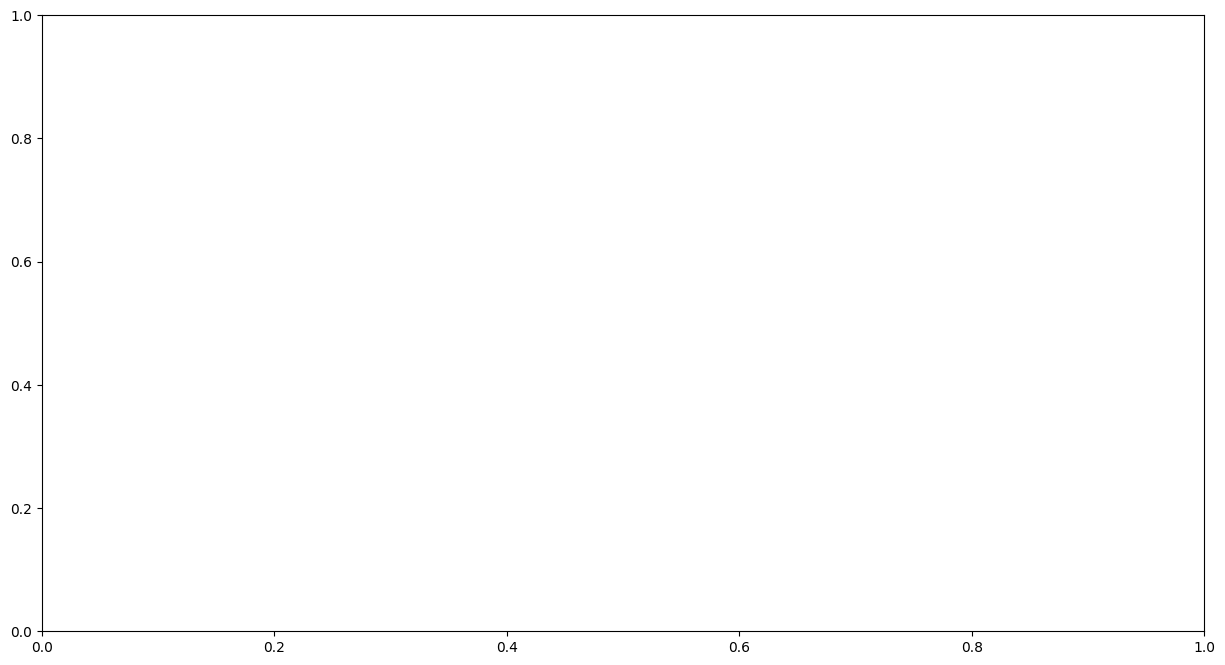

In [6]:
# for the plot
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]
# Create a colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(responses.keys()) - 1)

for frozen_theta0 in [False, True]:

    print(f'{frozen_theta0=}')
    print(50*'.-*')
    
    fig, ax = plt.subplots(figsize=(15, 8))

    for i_session, session in enumerate(responses.keys()):
        y = responses[session]

        logistic_model, loss = fit_data(theta_trials, y, frozen_theta0=frozen_theta0, verbose=False)
        print(f"for {session}, Loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.2f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.2e}, slope = {torch.exp(logistic_model.log_wt).item():.2e}")

        y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
        ax.plot(x_values, y_values, color=cmap(norm(i_session)), alpha=0.5, lw=2, label=session)

    ax.set_xlabel(r"orientation $\theta$", fontsize=20)
    ax.axhline(.5, color='k', linestyle='--')
    ax.axvline(0., color='b', linestyle='--')
    ax.set_yticks([0.0, 1.0])
    ax.set_yticklabels(["CCW", "CW"], fontsize=20)
    plt.show();


### optimize learning parameters with optuna

In [ ]:
logistic_model, loss = fit_data(theta_trials, y, verbose=True)

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = 'theta'
path_save_optuna = os.path.join('/tmp', f'optuna_{study_name}.sqlite3') # global name
# %rm {path_save_optuna}


In [ ]:
def objective(trial):
    vars = dict(verbose = False,  num_epochs=num_epochs//2)
    max_threshold = .999
    vars['batch_size'] = trial.suggest_int('batch_size', 2, 64, log=True, step=1)
    scale = 4
    scale = 2
    vars['etab1'] = trial.suggest_float('etab1', etab1/scale, min(etab1*scale, max_threshold), log=True)
    vars['etab2'] = trial.suggest_float('etab2', etab2/scale, min(etab2*scale, max_threshold), log=True)
    vars['learning_rate'] = trial.suggest_float('learning_rate', learning_rate / scale, learning_rate * scale, log=True)
    vars['amsgrad'] = trial.suggest_categorical('amsgrad', [True, False])
    # initialization
    vars['logit0'] = trial.suggest_float('logit0', logit0 - scale, logit0 + scale, log=False)
    vars['log_wt'] = trial.suggest_float('log_wt', log_wt - scale, log_wt + scale, log=False)
    # scale = 4
    # vars['theta0'] = trial.suggest_float('theta0', theta0 - scale, theta0 + scale, log=False)

    loss = 0
    for session in responses.keys():    
        y = responses[session]
        _, loss_ = fit_data(theta_trials, y, **vars)
        loss += loss_
    return loss/len(filenames_valid)

print(50*'=')
sampler = optuna.samplers.TPESampler(multivariate=True)
study = optuna.create_study(direction='minimize', load_if_exists=True, sampler=sampler, storage=f"sqlite:///{path_save_optuna}", study_name=study_name)
study.optimize(objective, n_trials=max((200-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)
print(50*'=')

In [ ]:
print(50*'-.')
print(f"Best params: {study.best_params}")
print(f"Best value: {study.best_value:.3f} at {now.strftime("%Y-%m-%d %H:%M:%S")}")
print(50*'-')